In [1]:
# Connecting to Database

from IPython.display import display_html
from sqlalchemy import create_engine
import pandas as pd

host='localhost'
database='eicu'
username='purav'
port = "5432"

postgres_str =('postgresql://'+username+':root'+'@'+host+':'+port+'/'+database)
#   Create the connection
cnx = create_engine(postgres_str)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Getting from the Database for BaseLine model

patient = pd.read_sql('SELECT * FROM eicuu.patient', cnx)
apache = pd.read_sql('SELECT * FROM eicuu.apacheapsvar', cnx)
hospital = pd.read_sql('Select * from eicuu.hospital',cnx)

result = pd.merge(patient,
                 apache,
                 on="patientunitstayid", 
                 how='inner')

In [4]:
result=result.drop(['patienthealthsystemstayid', 'ethnicity','wardid','apacheadmissiondx','admissionheight','hospitaladmittime24',
        'hospitaladmitoffset','hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation','unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24','meanbp',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid','apacheapsvarid', 'intubated','dialysis','meds', 'hematocrit',
       'creatinine', 'albumin','pco2','glucose'],axis = 1)
print(result.columns)

Index(['patientunitstayid', 'gender', 'age', 'hospitalid',
       'hospitaldischargestatus', 'vent', 'eyes', 'motor', 'verbal', 'urine',
       'wbc', 'temperature', 'respiratoryrate', 'sodium', 'heartrate', 'ph',
       'pao2', 'bun', 'bilirubin', 'fio2'],
      dtype='object')


In [5]:
# Merging patient data with hospital data

baseline = pd.merge(result,
                 hospital,
                 on="hospitalid", 
                 how='inner')

print(baseline.columns)

Index(['patientunitstayid', 'gender', 'age', 'hospitalid',
       'hospitaldischargestatus', 'vent', 'eyes', 'motor', 'verbal', 'urine',
       'wbc', 'temperature', 'respiratoryrate', 'sodium', 'heartrate', 'ph',
       'pao2', 'bun', 'bilirubin', 'fio2', 'numbedscategory', 'teachingstatus',
       'region'],
      dtype='object')


In [6]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [7]:
# Preprocessing the data

X_temp = baseline
X_temp = X_temp[X_temp.hospitaldischargestatus != '']

# Mean Imputation for Age
X_temp.replace({'age': {'': '0','> 89': '91'}},inplace=True)
X_temp = X_temp.astype({"age": np.int})
X_temp.replace({'age': {0: int(X_temp.age.mean())}},inplace=True)

# Removing age below 18
X_temp = X_temp[X_temp.age >= 18]


# Removing records with no gender given
X_temp = X_temp[X_temp.gender != '']


# Temporary dropping label so that we do not convert them into dummy variables
hds = pd.DataFrame(X_temp['hospitaldischargestatus'])
X_temp.drop(['hospitaldischargestatus'],axis=1,inplace=True)


# Converting categorical variables into numerical ones
X_cat = X_temp.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X_temp.select_dtypes(include=['int64', 'float64'])                                                                                                         

X_cat = pd.get_dummies(X_cat)                                                                                                                                 

X_temp=pd.concat([X_cat,X_dog,hds],axis=1)


# Converting the label into 1 and 0
hds = pd.DataFrame(X_temp.hospitaldischargestatus.map({'Alive': 1, 'Expired': 0}))
X_temp['hospitaldischargestatus'] = hds['hospitaldischargestatus']

# Seperating different label samples for experimentation
X_alive = X_temp.loc[X_temp['hospitaldischargestatus'] == 1]
X_expired = X_temp.loc[X_temp['hospitaldischargestatus'] == 0]

print("Alive vs Expired sample count")
print(X_alive.shape,X_expired.shape)

# For Trying different ratio of samples from each label

# X_alive_restricted = X_alive.tail(16000)
# X_temp = X_alive_restricted.append(X_expired)


# Dropping foreign,primary keys and label for proper model training
Y = pd.DataFrame(X_temp['hospitaldischargestatus'])                
X = pd.DataFrame(X_temp.drop(['patientunitstayid'],axis=1))
X = pd.DataFrame(X.drop(['hospitalid'],axis=1))
X = pd.DataFrame(X.drop(['hospitaldischargestatus'],axis=1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify=Y)


# Model Training


log_f1_score = 0
log_auc_score = 0
n =5
skf=StratifiedKFold(n_splits=n)
for train_index, test_index in skf.split(X_train, Y_train):

    x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    log_regressor   = LogisticRegression(penalty='l1', max_iter = 1e8, class_weight='balanced')
    # log_regressor = GridSearchCV(estimator=log_regressor, param_grid={'C':np.logspace(-4,4,10)}, cv= 5)
    log_regressor.fit(x_train, y_train)

    pred =pd.DataFrame(log_regressor.predict(X_test),columns=["a"])

    log_f1_score+=(f1_score(Y_test,pred))/n
    log_auc_score+= roc_auc_score(Y_test,pred)/n

    print(confusion_matrix(Y_test,pred))
    
# print(X_train.columns)
# print(log_regressor.coef_)
print("Average F1 score",log_f1_score)
print("Average Auc Roc Score",log_auc_score)

Alive vs Expired sample count
(153037, 32) (16073, 32)
[[ 2376   839]
 [ 7157 23450]]
[[ 2380   835]
 [ 7190 23417]]
[[ 2371   844]
 [ 7126 23481]]
[[ 2381   834]
 [ 7255 23352]]
[[ 2366   849]
 [ 7133 23474]]
Average F1 score 0.8540059223570833
Average Auc Roc Score 0.7521652519440634


In [8]:
# Getting Ids for all the hospital for Leave one hospital out validation
ids = (result.hospitalid.unique())
print(ids)

[ 59  60  73  67  66  63  71  56  68  69 188  58  61  79 110 122  92 108
  83  95  84  93  86  90  85 102  96  94 141 143 144  91 142 123 125 135
 112 133 120 131 138 115 136 176 152 140 154 148 175 165 167 171 157 155
 146 174 158 164 179 151 156 184 197 194 198 199 209 208 217 264 181 183
 182 180 283 282 196 195 202 203 201 206 200 205 204 210 207 224 220 215
 212 226 227 244 245 243 246 252 251 248 253 249 250 266 258 256 267 259
 262 254 263 265 269 272 281 271 279 268 277 280 275 273 338 352 403 394
 382 391 312 307 300 318 310 301 303 397 383 411 323 413 416 417 423 420
 331 345 337 342 328 336 439 440 434 435 443 444 351 350 365 360 364 358
 353 355 357 356 363 361 400 390 381 388 389 387 384 402 407 393 399 398
 405 408 404 386 396 392 401 409 385 412 414 424 419 425 422 421 428 438
 429 437 433 436 445 452 449 447 459 458]


In [9]:
# Leave one hospital out

avg_f1 = 0

f1score=[]

count =0
for i in ids:

    X_train = X_temp[X_temp.hospitalid != i]
    X_test = X_temp[X_temp.hospitalid == i]

    X_train = pd.DataFrame(X_train.drop(['patientunitstayid'],axis=1))
    X_train = pd.DataFrame(X_train.drop(['hospitalid'],axis=1))
    X_test = pd.DataFrame(X_test.drop(['patientunitstayid'],axis=1))
    X_test = pd.DataFrame(X_test.drop(['hospitalid'],axis=1))

    Y_train = pd.DataFrame(X_train['hospitaldischargestatus'])                
    Y_test = pd.DataFrame(X_test['hospitaldischargestatus'])                

    X_train = pd.DataFrame(X_train.drop(['hospitaldischargestatus'],axis=1))
    X_test = pd.DataFrame(X_test.drop(['hospitaldischargestatus'],axis=1))

#     Checking if after preprocessing if any hospital does not have any samples left
    if not X_test.empty:
        
        count+=1
        log_regressor   = LogisticRegression(penalty='l1', max_iter = 1e8, class_weight='balanced')
        log_regressor.fit(X_train, Y_train)

        pred =pd.DataFrame(log_regressor.predict(X_test),columns=["a"])
        log_f1_score=(f1_score(Y_test,pred))
        
        f1score.append(log_f1_score)
        
#         print(confusion_matrix(Y_test,pred))
        avg_f1 += log_f1_score
        
print("Average F1 Score=", avg_f1/count)
print("Standard Deviation",np.std(f1score))

Average F1 Score= 0.8524069595514939
Standard Deviation 0.08869444750191051


In [31]:
from xgboost import XGBClassifier
from keras.utils import to_categorical
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

X_temp1 = baseline
X_temp1 = X_temp1[X_temp1.hospitaldischargestatus != '']

# Mean Imputation for Age
X_temp1.replace({'age': {'': '0','> 89': '91'}},inplace=True)
X_temp1 = X_temp1.astype({"age": np.int})
X_temp1.replace({'age': {0: int(X_temp1.age.mean())}},inplace=True)

# Removing age below 18
X_temp1 = X_temp1[X_temp1.age >= 18]

# Removing records with no gender given
X_temp1 = X_temp1[X_temp1.gender != '']

hds = pd.DataFrame(X_temp1.hospitaldischargestatus.map({'Alive': 1, 'Expired': 0}))

X_temp1["hospitaldischargestatus"] = hds["hospitaldischargestatus"]

X_alive = X_temp1.loc[X_temp1['hospitaldischargestatus'] == 1]
X_expired = X_temp1.loc[X_temp1['hospitaldischargestatus'] == 0]

# X_alive_restricted = X_alive.tail(16000)

# X_temp1 = X_alive_restricted.append(X_expired)

Y = pd.DataFrame(X_temp1['hospitaldischargestatus'])                

X = pd.DataFrame(X_temp1.drop(['patientunitstayid'],axis=1))
X = pd.DataFrame(X.drop(['hospitaldischargestatus'],axis=1))
X = pd.DataFrame(X.drop(['numbedscategory'],axis=1))
X = pd.DataFrame(X.drop(['hospitalid'],axis=1))

X_cat = X.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X.select_dtypes(include=['int64', 'float64'])                                                                                                         

X_cat = pd.get_dummies(X_cat)                                                                                                                                 

X=pd.concat([X_cat,X_dog],axis=1)

negative_class = len(X_alive.index)
positive_class = len(X_expired.index)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.iloc[:,0].values)

s = [250,400,500,600,700,800,1000,1250,1500]
# s=[50]
loss_dict = {}
f1_dict={}
roc_dict={}
Expired_correct_predict_dict={}

# Weight for Expired label smaples
weight = positive_class/negative_class

for i in s:
    xgb_c = XGBClassifier(max_depth=3, n_estimators=i, n_jobs=-1,scale_pos_weight=weight)
    xgb_c.fit(X_train, Y_train,)
    pred = xgb_c.predict(X_test)
    
    cfm = confusion_matrix(Y_test,pred)
    
    f1 = f1_score(Y_test,pred)
    roc = roc_auc_score(Y_test,pred)
    
#     for log loss as it needs one hot encoded data

    y = to_categorical(Y_test,2)
    pred = to_categorical(pred,2)
    y=y.astype(np.uint8)
    
    Loss = log_loss(y,pred)
    
#     Adding values to dictionary for plotting
    loss_dict[i]= Loss
    f1_dict[i]=f1
    roc_dict[i]=roc
    Expired_correct_predict_dict[i]=cfm[0][0]

    
# To print feautre importance 

#     asd = xgb_c.feature_importances_
#     e=pd.DataFrame(asd,columns=["Feature Importance"])
#     f=pd.DataFrame(X_train.columns,columns=["Feature Names"])
#     # print(f)
#     g=pd.concat([f,e],axis=1)
#     g.sort_values(by=['Feature Importance'])
#     print("XGBoost Feature Importance")
#     print(g.head(40))

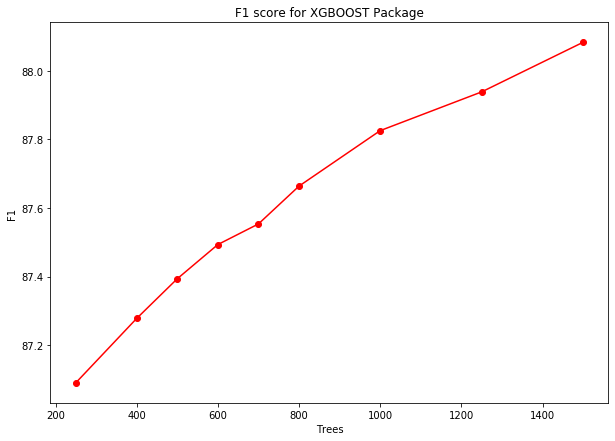

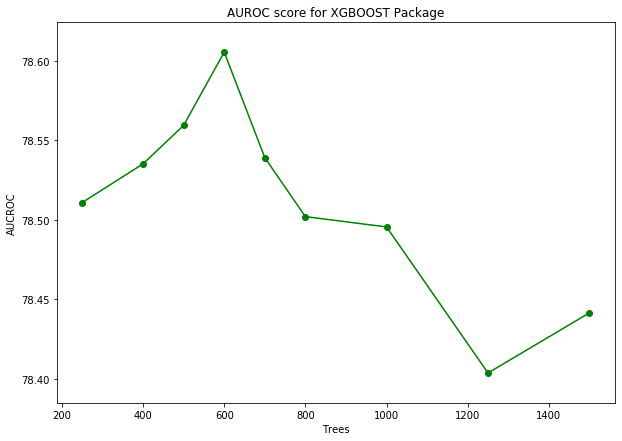

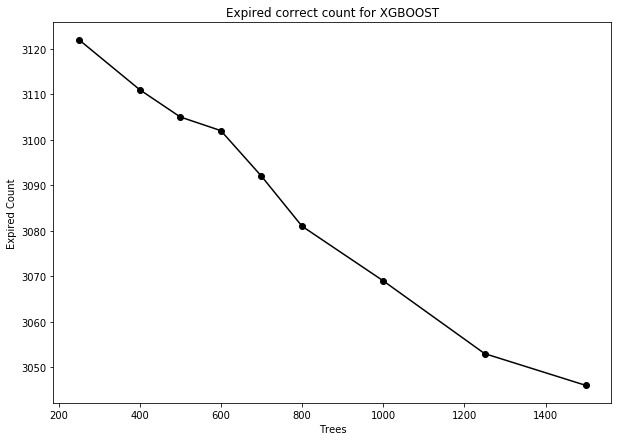

In [32]:
#  F1
plt.figure(figsize = (10,7))
plt.scatter([tree for tree in s], [f1_dict[tree]*100 for tree in s],color="red")
plt.plot([tree for tree in s], [f1_dict[tree]*100 for tree in s],color="red")
plt.title('F1 score for XGBOOST Package')
plt.xlabel('Trees')
plt.ylabel('F1')
plt.show()


#  ROC
plt.figure(figsize = (10,7))
plt.scatter([tree for tree in s], [roc_dict[tree]*100 for tree in s],color="green")
plt.plot([tree for tree in s], [roc_dict[tree]*100 for tree in s],color="green")
plt.title('AUROC score for XGBOOST Package')
plt.xlabel('Trees')
plt.ylabel('AUCROC')
plt.show()


# Expired Count

plt.figure(figsize = (10,7))
plt.scatter([tree for tree in s], [Expired_correct_predict_dict[tree] for tree in s],color="black")
plt.plot([tree for tree in s], [Expired_correct_predict_dict[tree] for tree in s],color="black")
plt.title('Expired correct count for XGBOOST')
plt.xlabel('Trees')
plt.ylabel('Expired Count')
plt.show()


In [10]:
# retrospective model

comorbidities = pd.read_csv("patient_co_morbidity.csv")
print(comorbidities.head())

   Patient  Congestiveheartfailure  Cardiacarrhythmias  Valvulardisease  \
0   141168                       2                   0                0   
1   141203                       0                   0                0   
2   141227                       0                   0                0   
3   141229                       3                   0                0   
4   141266                       1                   0                0   

   Pulmonarycirculationdisorders  Peripheralvasculardisorders  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   Hypertension,uncomplicated  Hypertension,complicated  Paralysis  \
0                           0                         0          0   
1                 

In [15]:
final_df = pd.merge(comorbidities,
                 X_temp1,
                 left_on="Patient",
                 right_on="patientunitstayid", 
                 how='inner')

print(len(final_df.patientunitstayid.index))

159666


In [21]:
X1 = final_df

X1.dropna(inplace=True)

Y1 = pd.DataFrame(X1['hospitaldischargestatus']) 

X1 = pd.DataFrame(X1.drop(['patientunitstayid'],axis=1))
X1 = pd.DataFrame(X1.drop(['Patient'],axis=1))
X1 = pd.DataFrame(X1.drop(['hospitalid'],axis=1))               
X1 = pd.DataFrame(X1.drop(['hospitaldischargestatus'],axis=1))
X1 = pd.DataFrame(X1.drop(['numbedscategory'],axis=1))

X_cat = X1.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X1.select_dtypes(include=['int64', 'float64'])                                                                                                         

X_cat = pd.get_dummies(X_cat)                                                                                                                                 

X1=pd.concat([X_cat,X_dog],axis=1)


In [19]:
# Data left after preprocessing
print(X1.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1)

log_f1_score = 0
log_auc_score = 0
n =5

skf=StratifiedKFold(n_splits=n)
for train_index, test_index in skf.split(X_train, Y_train):

    x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    log_regressor   = LogisticRegression(penalty='l1', max_iter = 1e8, class_weight='balanced')
    # log_regressor = GridSearchCV(estimator=log_regressor, param_grid={'C':np.logspace(-4,4,10)}, cv= 5)
    log_regressor.fit(X_train, Y_train)

    pred =pd.DataFrame(log_regressor.predict(X_test),columns=["a"])
    log_f1_score+=(f1_score(Y_test,pred))/n
    log_auc_score+= roc_auc_score(Y_test,pred)/n

    print(confusion_matrix(Y_test,pred))
    
# print(X_train.columns)
# print(log_regressor.coef_)
print("Retrospective model")
print("Average F1 score",log_f1_score)
print("Average Auc Roc Score",log_auc_score)

(135371, 61) (135371, 1)
[[ 2398   881]
 [ 6896 23668]]
[[ 2399   880]
 [ 6896 23668]]
[[ 2399   880]
 [ 6896 23668]]
[[ 2397   882]
 [ 6897 23667]]
[[ 2398   881]
 [ 6896 23668]]
Average F1 score 0.8588888930415801
Average Auc Roc Score 0.7528750284525876


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1)

s = [250,400,500,600,700,800,1000,1250,1500]

loss_dict = {}
f1_dict={}
roc_dict={}
Expired_correct_predict_dict={}

weight = positivue_class/negative_class
for i in s:
    xgb_c = XGBClassifier(max_depth=3, n_estimators=i, n_jobs=-1,scale_pos_weight=weight)
    xgb_c.fit(X_train, Y_train,)
    pred = xgb_c.predict(X_test)
    
    cfm = confusion_matrix(Y_test,pred)
    
    f1 = f1_score(Y_test,pred)
    roc = roc_auc_score(Y_test,pred)
    
#     for log loss as it needs one hot encoded data

    y = to_categorical(Y_test,2)
    pred = to_categorical(pred,2)
    y=y.astype(np.uint8)
    
    Loss = log_loss(y,pred)
    
#     Adding values to dictionary for plotting
    loss_dict[i]= Loss
    f1_dict[i]=f1
    roc_dict[i]=roc
    Expired_correct_predict_dict[i]=cfm[0][0]
    
# Display Feature importance

#     asd = xgb_c.feature_importances_
#     e=pd.DataFrame(asd,columns=["Feature Importance"])
#     f=pd.DataFrame(X_train.columns,columns=["Feature Names"])
#     # print(f)
#     g=pd.concat([f,e],axis=1)
#     g.sort_values(by=['Feature Importance'])
#     print("XGBoost Feature Importance")
#     print(g.head(40))

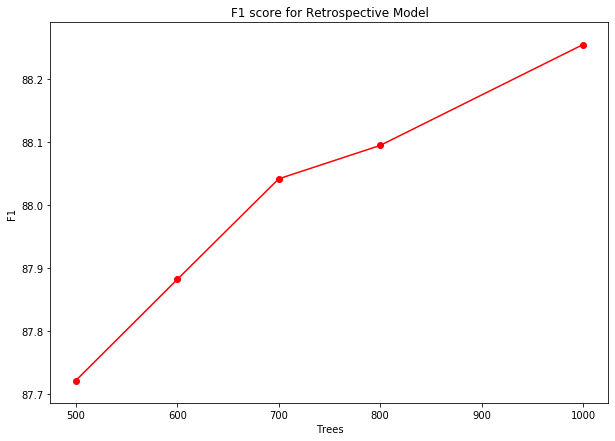

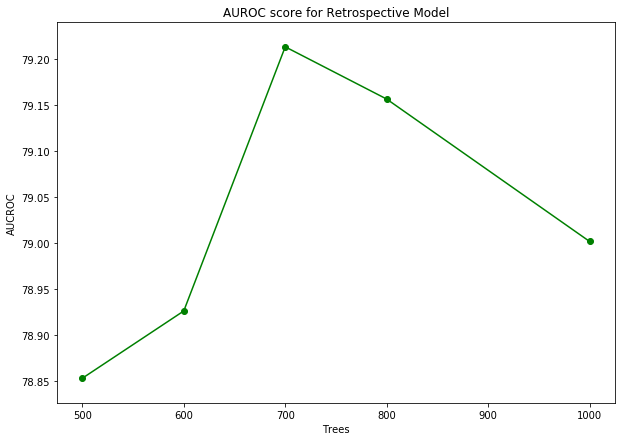

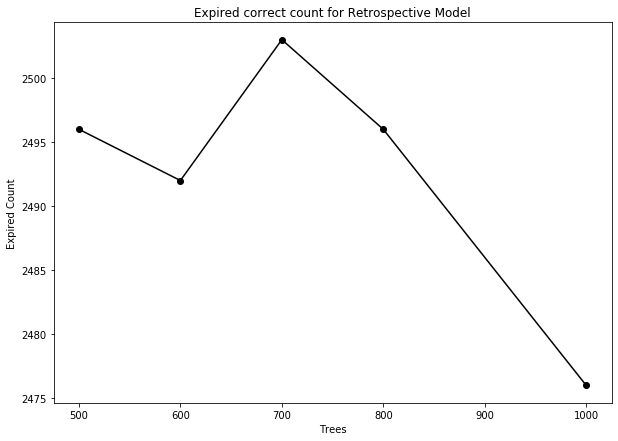

In [30]:
#  F1
plt.figure(figsize = (10,7))
plt.scatter([tree for tree in s], [f1_dict[tree]*100 for tree in s],color="red")
plt.plot([tree for tree in s], [f1_dict[tree]*100 for tree in s],color="red")
plt.title('F1 score for Retrospective Model')
plt.xlabel('Trees')
plt.ylabel('F1')
plt.show()


#  ROC
plt.figure(figsize = (10,7))
plt.scatter([tree for tree in s], [roc_dict[tree]*100 for tree in s],color="green")
plt.plot([tree for tree in s], [roc_dict[tree]*100 for tree in s],color="green")
plt.title('AUROC score for Retrospective Model')
plt.xlabel('Trees')
plt.ylabel('AUCROC')
plt.show()


# Expired Count
plt.figure(figsize = (10,7))
plt.scatter([tree for tree in s], [Expired_correct_predict_dict[tree] for tree in s],color="black")
plt.plot([tree for tree in s], [Expired_correct_predict_dict[tree] for tree in s],color="black")
plt.title('Expired correct count for Retrospective Model')
plt.xlabel('Trees')
plt.ylabel('Expired Count')
plt.show()